In [1]:
import os 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import json

In [2]:
import sys
sys.path.append('/home/ksmehrab/AttentionGrounding/ModelPlaygrounds/SegZero/EvaluationScripts')
from eval_base import compute_iou, remove_overlapping_boxes


In [3]:
############# Dataset-specific settings #############
# this needs to be changed to the train dataset 
instructpart_test_dir = "/data/VLMGroundingProject/Datasets/InstructPart/train1800"
masks_dir = os.path.join(instructpart_test_dir, "masks")
images_dir = os.path.join(instructpart_test_dir, "images")
val_filenames = os.listdir(images_dir)
###################################################### 

In [4]:
def load_mask_and_parse_name(image_name, masks_dir):
    """
    Load mask and extract object and part names from filename.
    
    Args:
        image_name: Name of the image file (with or without extension)
        masks_dir: Directory containing the mask files
    
    Returns:
        mask: Loaded mask as numpy array
        object_name: Name of the object
        part_name: Name of the part
    """
    #get basename
    basename = os.path.splitext(image_name)[0]
    
    # mask 
    mask_path = os.path.join(masks_dir, f"{basename}.png")
    mask = np.array(Image.open(mask_path))
    
    # parse the filename: image_id-object_name-part_name
    filename_parts = basename.split('-')
    part_name = filename_parts[-1]
    object_name = filename_parts[-2]

    return mask, object_name, part_name

In [5]:
def visualize_mask_with_bboxes(image_name, images_dir, bboxes):
    """
    Display an image with mask overlay and bounding boxes around each segment.
    """
    image_path = os.path.join(images_dir, image_name)
    image = Image.open(image_path)
    
    mask, object_name, part_name = load_mask_and_parse_name(image_name, masks_dir)
    # figure
    plt.figure(figsize=(5, 4))
    plt.imshow(image)
    
    # overlay 
    colored_mask = np.zeros((*mask.shape, 4))
    colored_mask[mask > 0] = [1, 0, 0, 0.5]  # Red with 50% transparency
    plt.imshow(colored_mask)

    # draw bboxes
    ax = plt.gca()
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min
        
        rect = plt.Rectangle((x_min, y_min), width, height, 
                            fill=False, edgecolor='yellow', linewidth=2)
        ax.add_patch(rect)
    
    plt.title(f"Object: {object_name} | Part: {part_name} | Segments: {len(bboxes)}", 
             fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return bboxes

In [10]:
def boxes_intersect(box1, box2):
    """
    Check if two boxes intersect (have any overlap).
    
    Args:
        box1, box2: Bounding boxes in format [x_min, y_min, x_max, y_max]
    
    Returns:
        True if boxes intersect, False otherwise
    """
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2
    
    # Boxes intersect if they overlap in both x and y dimensions
    x_overlap = x_min1 < x_max2 and x_max1 > x_min2
    y_overlap = y_min1 < y_max2 and y_max1 > y_min2
    
    return x_overlap and y_overlap


def merge_intersecting_boxes(bboxes):
    """
    Merge intersecting bounding boxes into groups and create merged boxes.
    
    Args:
        bboxes: List of bounding boxes in format [x_min, y_min, x_max, y_max]
    
    Returns:
        List of merged bounding boxes
    """
    if not bboxes:
        return []
    
    n = len(bboxes)
    # Track which group each box belongs to (-1 means not assigned yet)
    box_to_group = [-1] * n
    groups = {}
    group_id = 0
    
    # Assign boxes to groups
    for i in range(n):
        if box_to_group[i] == -1:
            # Start a new group
            groups[group_id] = [i]
            box_to_group[i] = group_id
            
            # Find all boxes that intersect with any box in this group
            changed = True
            while changed:
                changed = False
                for j in range(n):
                    if box_to_group[j] == -1:
                        # Check if box j intersects with any box in current group
                        for box_idx in groups[group_id]:
                            if boxes_intersect(bboxes[j], bboxes[box_idx]):
                                groups[group_id].append(j)
                                box_to_group[j] = group_id
                                changed = True
                                break
            
            group_id += 1
    
    # Merge boxes in each group
    merged_boxes = []
    for group_indices in groups.values():
        # Get all boxes in this group
        group_boxes = [bboxes[i] for i in group_indices]
        
        # Find min x_min, y_min and max x_max, y_max
        x_min = min(box[0] for box in group_boxes)
        y_min = min(box[1] for box in group_boxes)
        x_max = max(box[2] for box in group_boxes)
        y_max = max(box[3] for box in group_boxes)
        
        merged_boxes.append([x_min, y_min, x_max, y_max])
    
    return merged_boxes

In [13]:
with open("/data/VLMGroundingProject/Datasets/InstructPart/train1800/sam3_bboxes_0.json", "r") as f:
    data = json.load(f)

{'image_name': 'suitcase_000303-suitcase-telescopic_handle.jpg', 'text_prompt': "suitcase's telescopic_handle", 'intersection': 4881, 'union': 14125, 'pred_bboxes': [[250, 5, 405, 241]]}


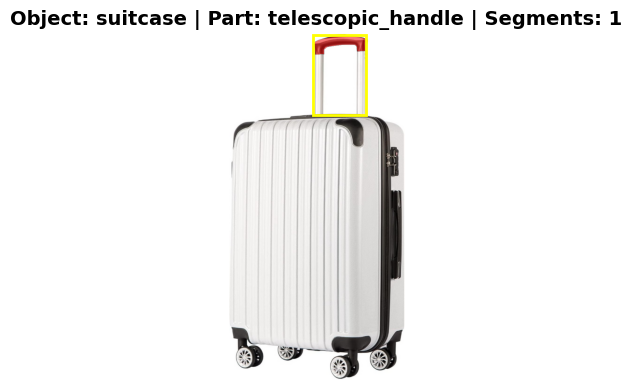

{'image_name': 'bed_002611-bed-sleeping_surface.jpg', 'text_prompt': "bed's sleeping_surface", 'intersection': 291927, 'union': 307122, 'pred_bboxes': [[562, 398, 1023, 767], [0, 408, 514, 767]]}


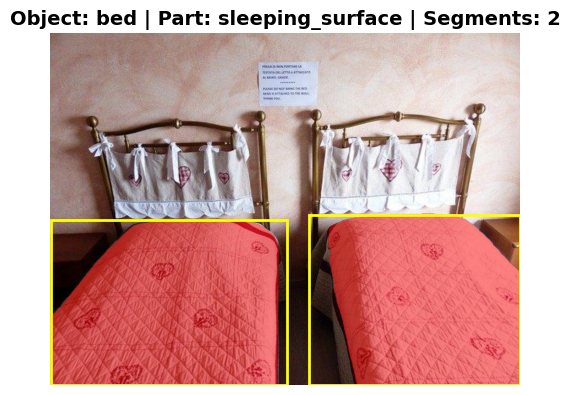

{'image_name': 'bench_001586-bench-seat.jpg', 'text_prompt': "bench's seat", 'intersection': 35069, 'union': 288626, 'pred_bboxes': [[43, 114, 903, 709], [128, 404, 144, 410], [512, 505, 526, 512], [528, 505, 542, 518], [563, 506, 563, 508], [441, 516, 442, 516], [659, 516, 660, 517], [666, 516, 666, 516], [655, 522, 655, 522], [679, 523, 681, 525], [757, 532, 764, 544], [757, 547, 761, 549], [247, 556, 247, 557], [314, 557, 314, 557], [310, 559, 312, 560], [372, 563, 376, 574], [281, 564, 300, 570], [368, 572, 369, 573], [376, 578, 378, 578], [428, 586, 428, 587], [614, 586, 618, 590], [671, 587, 690, 592], [693, 587, 698, 592], [602, 588, 612, 595], [636, 589, 640, 594], [615, 594, 616, 595], [673, 594, 673, 594], [625, 595, 634, 610], [607, 598, 618, 610], [659, 616, 659, 616]]}


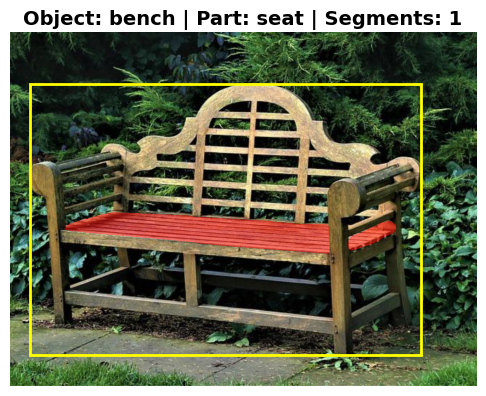

{'image_name': '3060105507_91bcc3533c_o-spoon-handle.jpg', 'text_prompt': "spoon's handle", 'intersection': 140353, 'union': 149246, 'pred_bboxes': [[734, 551, 1667, 1130]]}


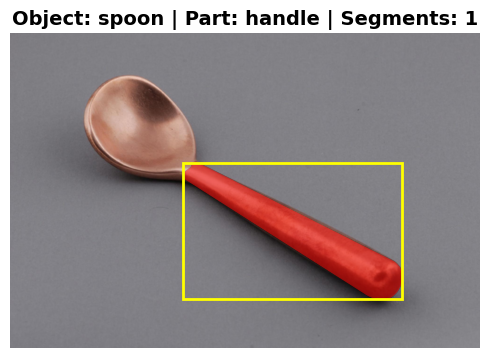

{'image_name': 'scissors_002665-scissors-handle.jpg', 'text_prompt': "scissors's handle", 'intersection': 52289, 'union': 56938, 'pred_bboxes': [[525, 61, 742, 259], [536, 228, 978, 385]]}


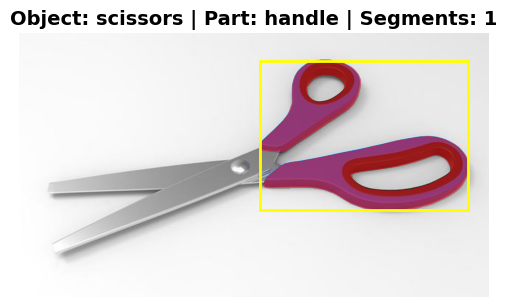

{'image_name': '3060104239_71b1dc449d_o-spoon-handle.jpg', 'text_prompt': "spoon's handle", 'intersection': 77795, 'union': 83636, 'pred_bboxes': [[1037, 693, 1693, 981]]}


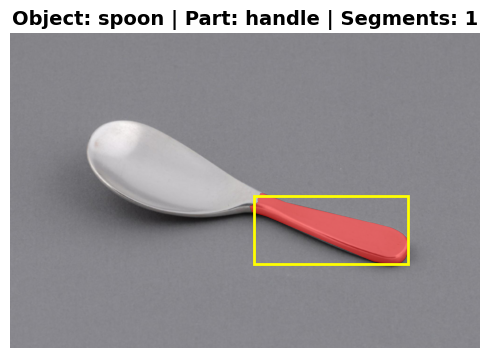

{'image_name': 'bench_003147-bench-seat.jpg', 'text_prompt': "bench's seat", 'intersection': 27332, 'union': 219092, 'pred_bboxes': [[156, 116, 919, 681], [766, 262, 766, 262], [328, 442, 328, 443], [324, 444, 326, 446], [318, 452, 323, 452], [637, 466, 640, 466]]}


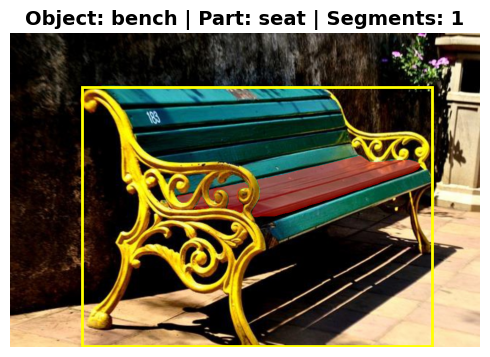

{'image_name': 'scissors_000449-scissors-handle.jpg', 'text_prompt': "scissors's handle", 'intersection': 35615, 'union': 41939, 'pred_bboxes': [[615, 326, 948, 448], [572, 397, 852, 636]]}


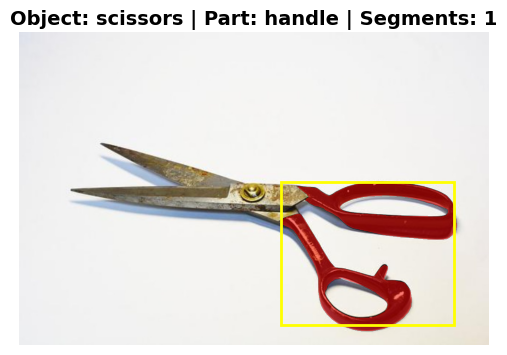

{'image_name': 'suitcase_000375-suitcase-static_handle.jpg', 'text_prompt': "suitcase's static_handle", 'intersection': 2144, 'union': 16684, 'pred_bboxes': [[191, 539, 313, 633], [583, 652, 838, 869]]}


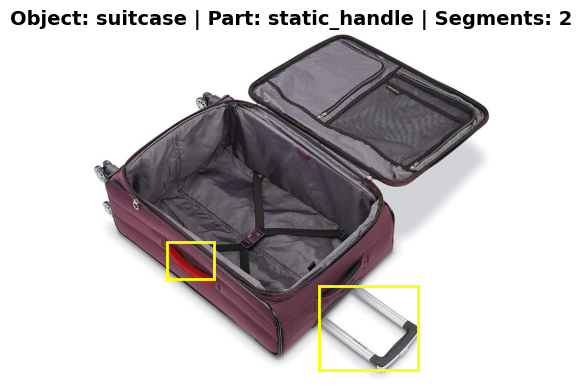

{'image_name': 'bench_001949-bench-seat.jpg', 'text_prompt': "bench's seat", 'intersection': 44288, 'union': 156058, 'pred_bboxes': [[151, 121, 868, 602]]}


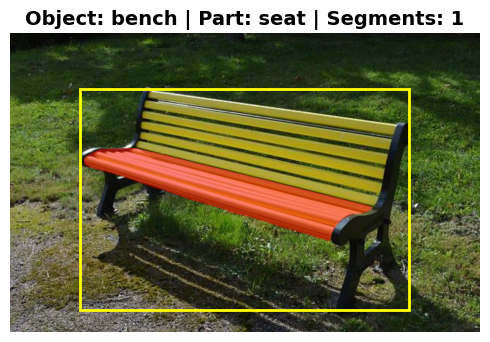

{'image_name': 'fork_000095-fork-tines.jpg', 'text_prompt': "fork's tines", 'intersection': 22575, 'union': 38480, 'pred_bboxes': [[196, 733, 439, 884], [245, 798, 523, 977], [342, 830, 344, 831], [519, 836, 521, 839]]}


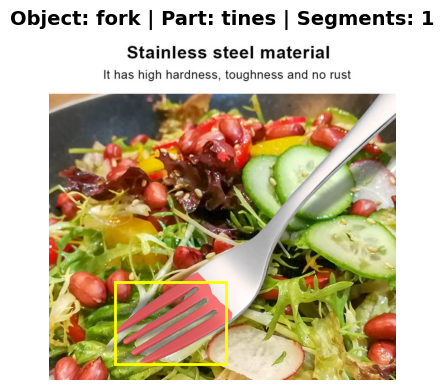

{'image_name': 'suitcase_001127-suitcase-telescopic_handle.jpg', 'text_prompt': "suitcase's telescopic_handle", 'intersection': 7625, 'union': 19021, 'pred_bboxes': [[233, 7, 429, 295]]}


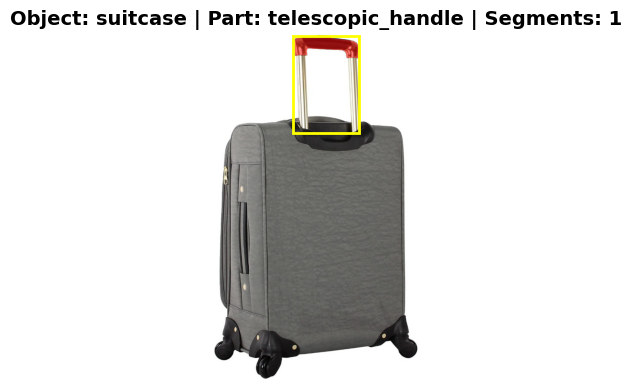

{'image_name': 'scissors_000924-scissors-blades.jpg', 'text_prompt': "scissors's blades", 'intersection': 12382, 'union': 13944, 'pred_bboxes': [[71, 541, 436, 598]]}


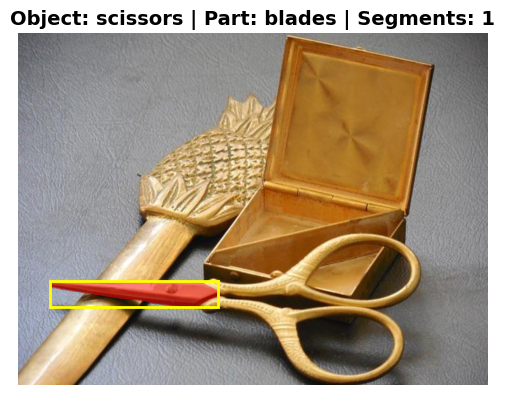

{'image_name': 'fork_003424-fork-tines.jpg', 'text_prompt': "fork's tines", 'intersection': 13038, 'union': 20179, 'pred_bboxes': [[807, 352, 874, 458], [907, 398, 977, 510], [736, 505, 792, 603]]}


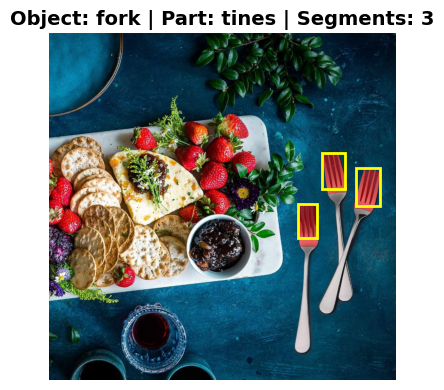

{'image_name': 'bed_002837-bed-sleeping_surface.jpg', 'text_prompt': "bed's sleeping_surface", 'intersection': 158815, 'union': 168980, 'pred_bboxes': [[0, 516, 915, 767], [763, 622, 769, 623], [798, 632, 803, 633], [894, 651, 894, 651], [897, 658, 915, 663], [882, 665, 883, 667], [917, 672, 918, 673], [869, 680, 869, 682], [877, 696, 886, 698], [894, 696, 899, 698], [889, 697, 892, 697], [911, 697, 914, 698], [896, 704, 902, 705]]}


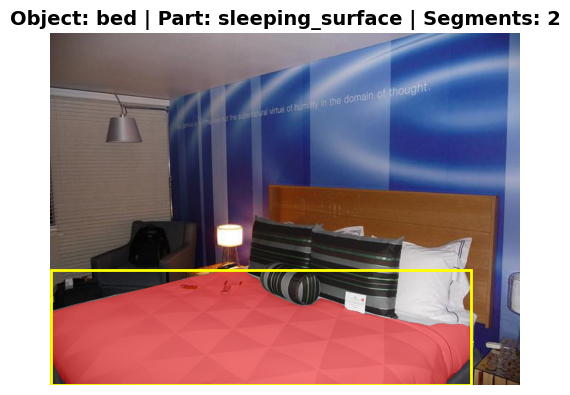

{'image_name': 'suitcase_001890-suitcase-static_handle.jpg', 'text_prompt': "suitcase's static_handle", 'intersection': 3451, 'union': 4947, 'pred_bboxes': [[248, 220, 387, 283]]}


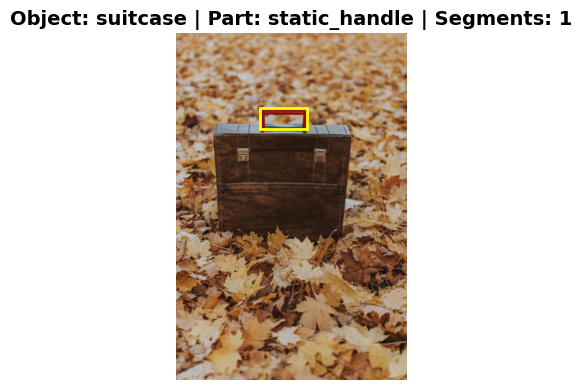

{'image_name': 'fork_002954-fork-tines.jpg', 'text_prompt': "fork's tines", 'intersection': 12028, 'union': 20409, 'pred_bboxes': [[174, 242, 329, 442]]}


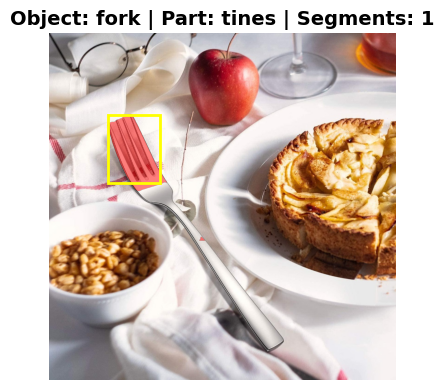

{'image_name': 'bed_003419-bed-sleeping_surface.jpg', 'text_prompt': "bed's sleeping_surface", 'intersection': 0, 'union': 12183}
Error processing bed_003419-bed-sleeping_surface.jpg: 'pred_bboxes'
{'image_name': 'bench_002456-bench-seat.jpg', 'text_prompt': "bench's seat", 'intersection': 28822, 'union': 177069, 'pred_bboxes': [[40, 104, 752, 680], [406, 670, 406, 670]]}


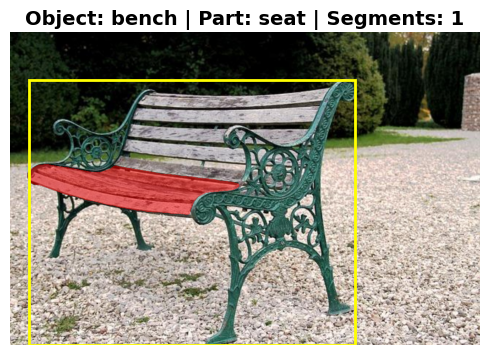

{'image_name': 'scissors_001372-scissors-handle.jpg', 'text_prompt': "scissors's handle", 'intersection': 60516, 'union': 67193, 'pred_bboxes': [[0, 206, 433, 382], [79, 255, 429, 489]]}


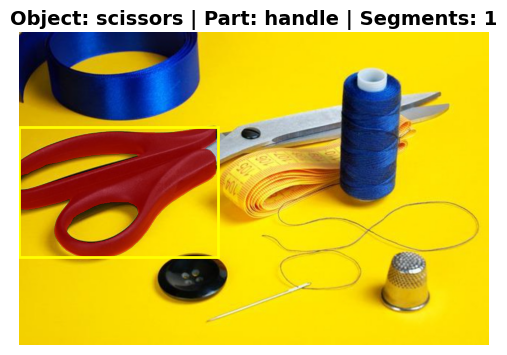

{'image_name': 'bed_000343-bed-sleeping_surface.jpg', 'text_prompt': "bed's sleeping_surface", 'intersection': 16222, 'union': 81396, 'pred_bboxes': [[410, 449, 857, 617]]}


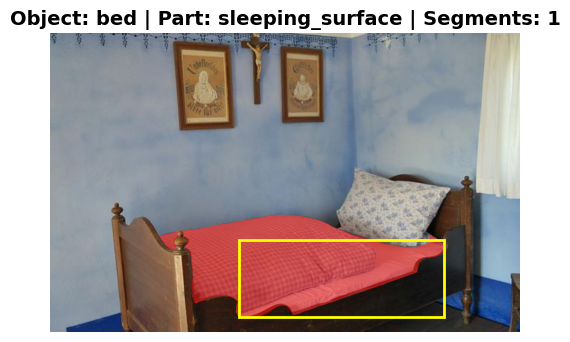

{'image_name': 'bench_000490-bench-seat.jpg', 'text_prompt': "bench's seat", 'intersection': 61817, 'union': 276675, 'pred_bboxes': [[0, 226, 988, 678], [127, 445, 130, 448], [397, 445, 409, 449]]}


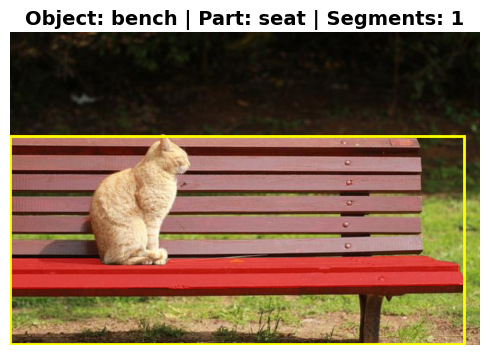

{'image_name': 'bench_002745-bench-seat.jpg', 'text_prompt': "bench's seat", 'intersection': 13832, 'union': 70014, 'pred_bboxes': [[281, 217, 628, 578], [347, 478, 350, 478]]}


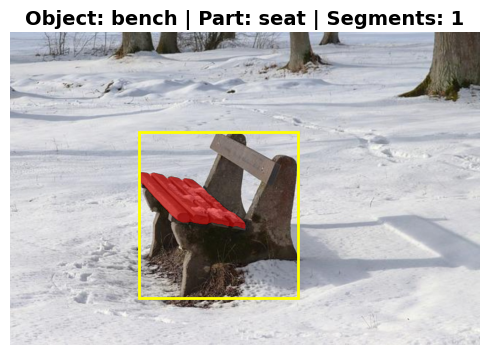

{'image_name': 'bench_002210-bench-seat.jpg', 'text_prompt': "bench's seat", 'intersection': 70721, 'union': 74238, 'pred_bboxes': [[284, 344, 885, 554]]}


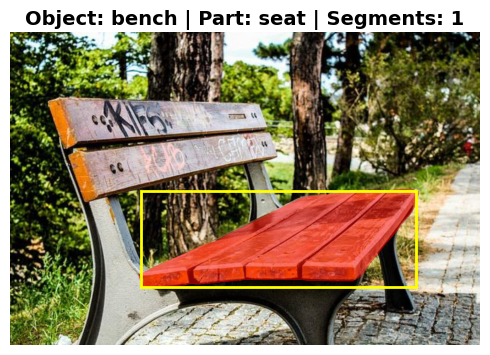

{'image_name': 'suitcase_002947-suitcase-telescopic_handle.jpg', 'text_prompt': "suitcase's telescopic_handle", 'intersection': 10571, 'union': 32288, 'pred_bboxes': [[199, 3, 419, 375], [39, 466, 83, 788]]}


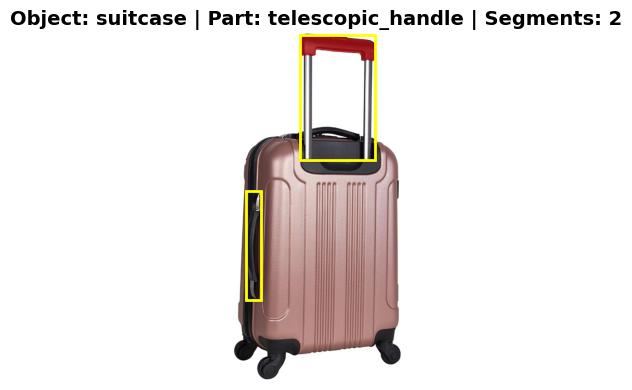

{'image_name': 'bed_003686-bed-sleeping_surface.jpg', 'text_prompt': "bed's sleeping_surface", 'intersection': 106666, 'union': 305125, 'pred_bboxes': [[166, 335, 1023, 677]]}


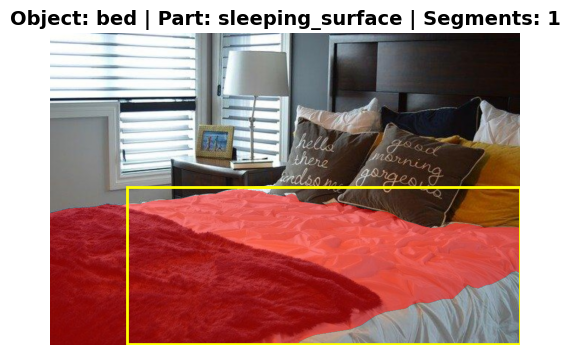

{'image_name': 'scissors_000423-scissors-handle.jpg', 'text_prompt': "scissors's handle", 'intersection': 29473, 'union': 33063, 'pred_bboxes': [[597, 239, 894, 375], [562, 385, 841, 585]]}


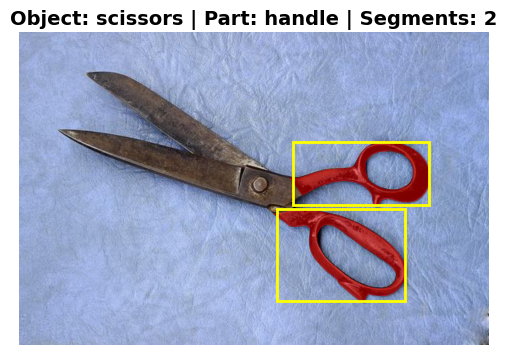

{'image_name': 'bed_002716-bed-sleeping_surface.jpg', 'text_prompt': "bed's sleeping_surface", 'intersection': 0, 'union': 16726}
Error processing bed_002716-bed-sleeping_surface.jpg: 'pred_bboxes'
{'image_name': 'suitcase_003030-suitcase-static_handle.jpg', 'text_prompt': "suitcase's static_handle", 'intersection': 4798, 'union': 16631, 'pred_bboxes': [[289, 0, 426, 255], [84, 461, 111, 685]]}


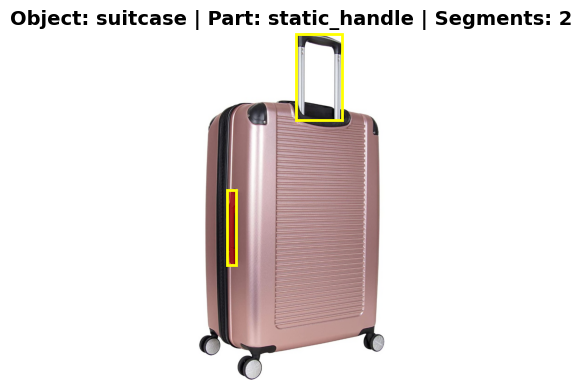

{'image_name': 'scissors_001418-scissors-handle.jpg', 'text_prompt': "scissors's handle", 'intersection': 66730, 'union': 73111, 'pred_bboxes': [[466, 61, 777, 287], [548, 164, 913, 383]]}


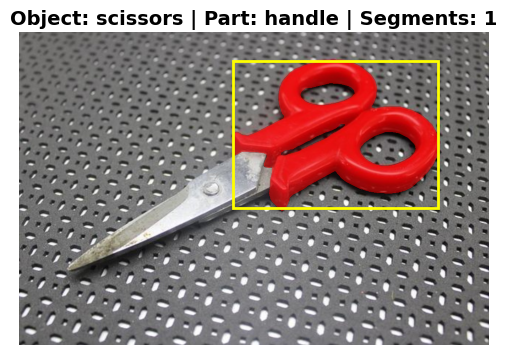

{'image_name': 'bed_001718-bed-sleeping_surface.jpg', 'text_prompt': "bed's sleeping_surface", 'intersection': 170108, 'union': 243719, 'pred_bboxes': [[402, 337, 945, 574], [131, 401, 791, 767], [796, 603, 799, 609]]}


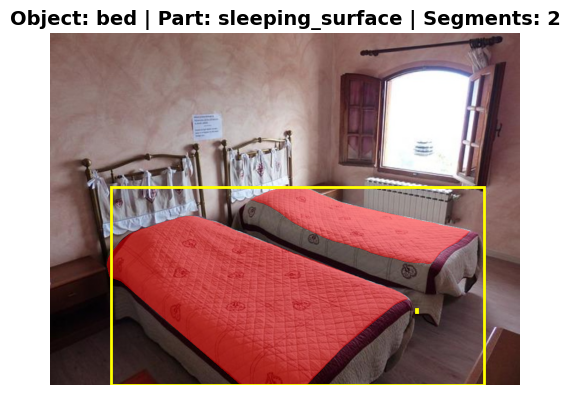

{'image_name': 'bench_000643-bench-seat.jpg', 'text_prompt': "bench's seat", 'intersection': 16363, 'union': 24406, 'pred_bboxes': [[608, 458, 837, 504], [316, 471, 578, 530], [95, 495, 285, 539]]}


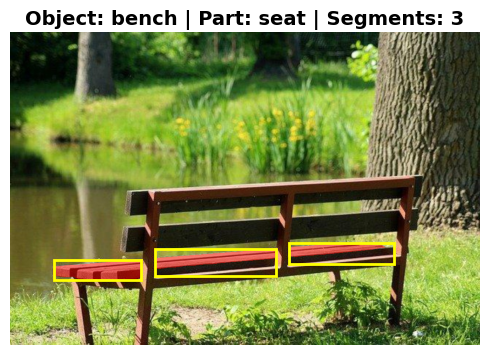

In [16]:
for d in data:
    print(d)
    image_name = d['image_name']
    try:
        bboxes = d['pred_bboxes']
        if len(bboxes) > 1:
            bboxes = remove_overlapping_boxes(bboxes)
        if len(bboxes) > 1:
            bboxes = merge_intersecting_boxes(bboxes)
        visualize_mask_with_bboxes(image_name, images_dir, bboxes)
    except Exception as e:
        print(f"Error processing {image_name}: {e}")


In [15]:
# cases to handle:
# 1. no boxes detected. we can put a dummy box with all zeros. Or we can put an empty list, that we can handle later during the training phase (if no boxes, iou is between the baseline box and the final box is automatically 0)
# 2. multiple boxes detected. we need to reject overlapping boxes. we also need to merge intersecting boxes. if two boxes intersect, we can take the min x_min and y_min, and max x_max and y_max to create a new box. we can break this down into two passes. In the first pass, we only merge all overlapping boxes. In the second pass, we merge all intersecting boxes. 